In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, get_eb_p_value, eb_selector, psi_E, v_i, pm_lambda
import pypoman
np.random.seed(123456789)

In [15]:
stratum_1_mean = 0.5
stratum_2_mean = 0.8
stratum_3_mean = 0.3
stratum_1 = np.ones(500) * stratum_1_mean
stratum_2 = np.ones(500) * stratum_2_mean
stratum_3 = np.ones(500) * stratum_3_mean
strata = [stratum_1, stratum_2, stratum_3]
np.mean(np.concatenate(strata))

0.5333333333333333

In [3]:
log_mart, p_value, selected_strata, eta_star_mat = get_eb_p_value(strata = strata, gamma = 1, fixed_strategy = True)

/Users/Jake/Dropbox/RLAs/alpha/Code/utils.py:528: RuntimeWarning: divide by zero encountered in true_divide
  lam_pm = np.sqrt(2 * np.log(1/alpha) / (lag_sigma_hat**2 * j * np.log(1 + j)))


In [5]:
log_marts, p_value, minimizing_etas, min_index, stratum_counts = get_eb_p_value(strata = strata, fixed_strategy = False)

In [6]:
#enumerated minimizing values of eta 
minimizing_etas

array([[0.5, 1. , 0. ],
       [0. , 1. , 0.5],
       [1. , 0.5, 0. ],
       [1. , 0. , 0.5],
       [0.5, 0. , 1. ],
       [0. , 0.5, 1. ]])

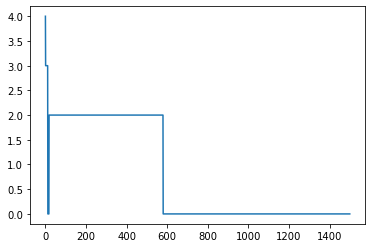

In [9]:
#which eta was selected at each time 
#[1,0.5,0] dominates, which is interesting b/c not the projection onto null means
plt.plot(min_index)

In [19]:
#the value of the null mean most selected
minimizing_etas[2,]

array([1. , 0.5, 0. ])

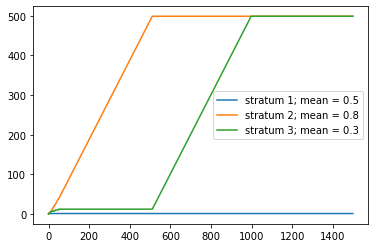

In [18]:
#stratum selection counts at each time for null 2, which was generally the minimizer
plt.plot(stratum_counts[:,0,2], label = "stratum 1; mean = " + str(stratum_1_mean))
plt.plot(stratum_counts[:,1,2], label = "stratum 2; mean = " + str(stratum_2_mean))
plt.plot(stratum_counts[:,2,2], label = "stratum 3; mean = " + str(stratum_3_mean))
plt.legend()

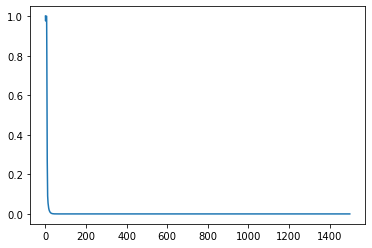

In [10]:
#p_value
plt.plot(p_value)

In [12]:
gamma = 1
run_in = 10
lam = np.array([.5, .5, .5])
#lam = None
N = np.array([len(x) for x in strata])
K = len(strata)
w = N/np.sum(N)
u = 1
marts = [np.ones(x) for x in N]
if lam is None:
    lam = [pm_lambda(stratum) for stratum in strata]
else:
    lam = [np.repeat(lam[k], N[k]) for k in np.arange(K)]
a = [np.cumsum(lam[k]*strata[k] - psi_E(lam[k]) * v_i(strata[k])) for k in np.arange(K)]
A = np.concatenate((np.expand_dims(w, axis = 0), np.expand_dims(-w, axis = 0), -np.identity(K), np.identity(K)))
b = np.concatenate((1/2 * np.ones(2), np.zeros(K), u*np.ones(K)))
vertices = np.stack(pypoman.compute_polytope_vertices(A, b), axis = 0)
minimizing_vertices = vertices[np.matmul(vertices, w) == 1/2,]
log_marts = np.zeros((np.sum(N), minimizing_vertices.shape[0]))
for v in np.arange(minimizing_vertices.shape[0]):
    eta = minimizing_vertices[v,]
    running_n = np.zeros(K)
    running_a = np.zeros(K)
    running_b = np.zeros(K)
    running_lam = np.array([x[0] for x in lam])
    i = 0
    while any((running_n < N - 1) & (eta != u)):
        next_stratum = eb_selector(running_a = running_a, running_n = running_n, running_b = running_b, N = N, u = u, eta = eta)
        running_n[next_stratum] += 1
        running_lam[next_stratum] = lam[next_stratum][int(running_n[next_stratum])]
        running_a[next_stratum] = a[next_stratum][int(running_n[next_stratum])]
        running_b[next_stratum] -= running_lam[next_stratum]
        log_marts[i,v] = np.sum(running_a) + np.dot(running_b, eta)
        i += 1
    #carry forward the last non-zero value of the martingale
    log_marts[i:,v] = log_marts[i-1,v]
min_log_mart = log_marts.min(axis = 1)
min_mart = np.exp(min_log_mart)
p_value = 1/np.maximum(1, min_mart)

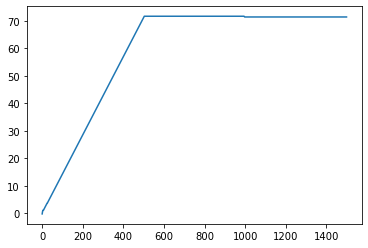

In [13]:
plt.plot(min_log_mart)